In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0"
module = "decoder"
task = "rte"

In [3]:
# assertions
assert model == "bigscience-T0"
assert module == "decoder"
assert task == "rte"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,mnli_crowdsource_with_targets,{premise} Using only the above description and...,instructive,True,"▁Yes, ▁No","0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it...",instructive,True,"▁Yes, ▁No","0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,"▁Yes, ▁No","0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypo...,instructive,True,"▁Yes, ▁No","0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hyp...",instructive,True,"▁Yes, ▁No","0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{h...",instructive,True,"▁Yes, ▁No","0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hy...",instructive,True,"▁Yes, ▁No","0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be tru...",instructive,True,"▁Yes, ▁No","0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypoth...",instructive,True,"▁Yes, ▁No","0, 1",False


## Comput CKA per prompt across layers

In [5]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    "mnli_crowdsource_with_targets",
    "based_on_previous_passage_with_targets",
    "infer_with_targets",
    "follow_with_targets",
    "imply_with_targets",
    "guaranteed_with_targets",
    "justified_with_targets",
    "must_be_true_with_targets",
    "should_assume_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
    "gpt_3_yes_no_without_targets",
]

In [6]:
representations = {}

for _, row in df.iterrows():
    prompt_name = row['name']

    if prompt_name in use_pattern:
        if prompt_name not in representations:
            representations[prompt_name] = {}

    for t in range(2):
        if t not in representations:
            representations[prompt_name][t] = {}
            
            for layer in range(0, 25):
                layer_key = f"{module}-{layer}"

                if layer_key not in representations[prompt_name][t]:
                    representations[prompt_name][t][layer_key] = {}

                file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5"
                
                # load hidden representations from hdf5 file
                representations[prompt_name][t][layer_key] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

In [7]:
representations.keys()

dict_keys(['gpt_3_yes_no_with_targets', 'mnli_crowdsource_with_targets', 'based_on_previous_passage_with_targets', 'infer_with_targets', 'follow_with_targets', 'imply_with_targets', 'guaranteed_with_targets', 'justified_with_targets', 'must_be_true_with_targets', 'should_assume_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets', 'gpt_3_yes_no_without_targets'])

In [8]:
# Compute CKA for every pattern across layers
np_cka = CKA()

cka_scores_pattern = {}
for pattern in list(representations.keys())[:]:
    if pattern not in cka_scores_pattern:
        cka_scores_pattern[pattern] = {}
    for t in range(2):
        cka_scores = []
        for layer1 in representations[pattern][t].keys():
            cka_scores_layer1 = []
            for layer2 in representations[pattern][t].keys():
                cka_score = np_cka.linear_CKA(representations[pattern][t][layer1], representations[pattern][t][layer2])
                cka_scores_layer1.append(cka_score)
            cka_scores.append(cka_scores_layer1)
        cka_scores = np.asarray(cka_scores)
        cka_scores_pattern[pattern][t] = cka_scores

In [9]:
cka_scores_pattern['gpt_3_yes_no_with_targets'][0].shape

(25, 25)

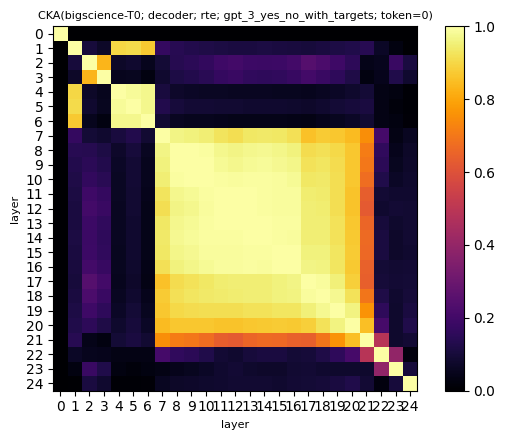

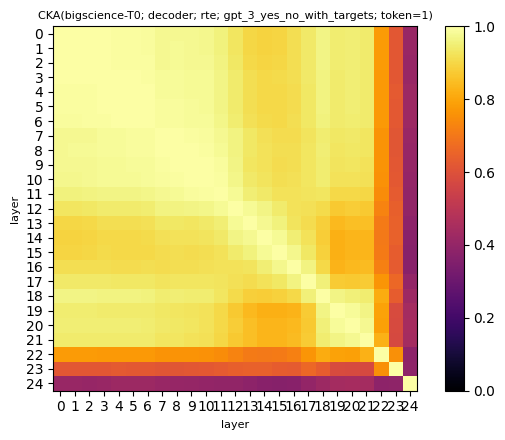

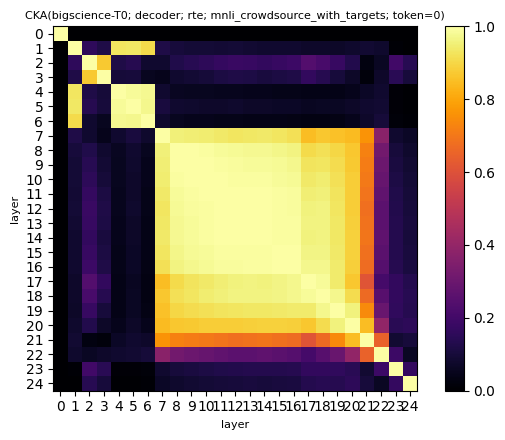

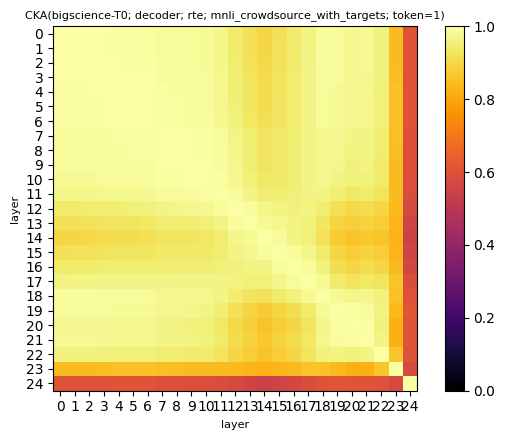

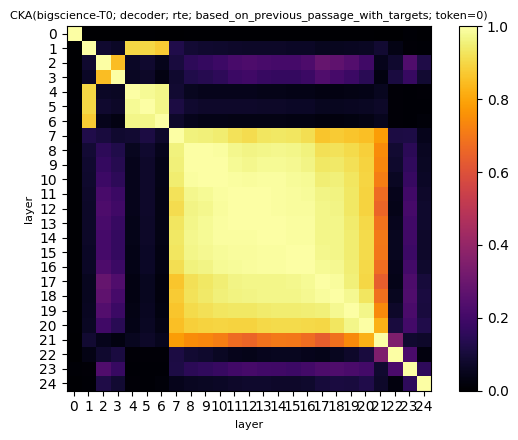

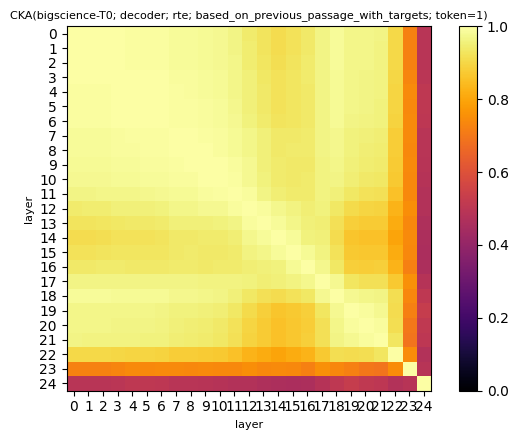

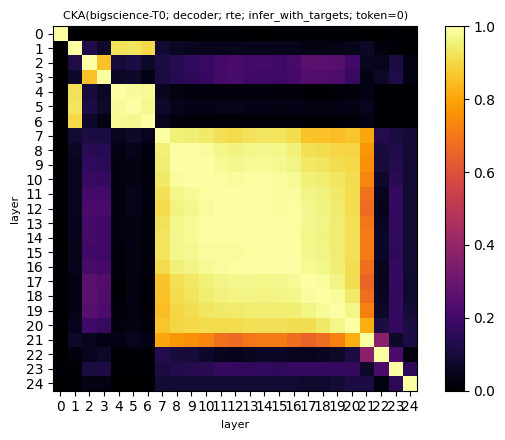

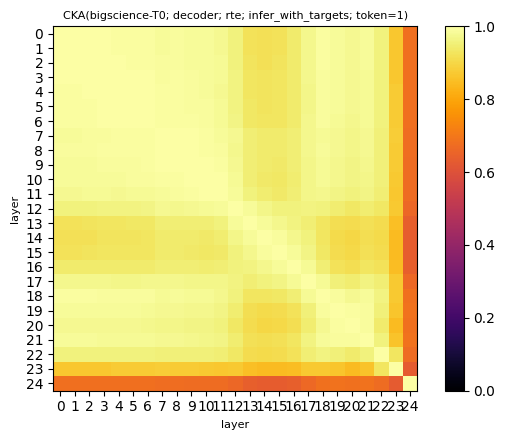

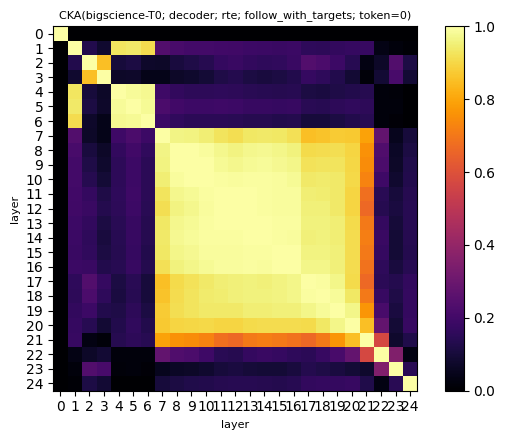

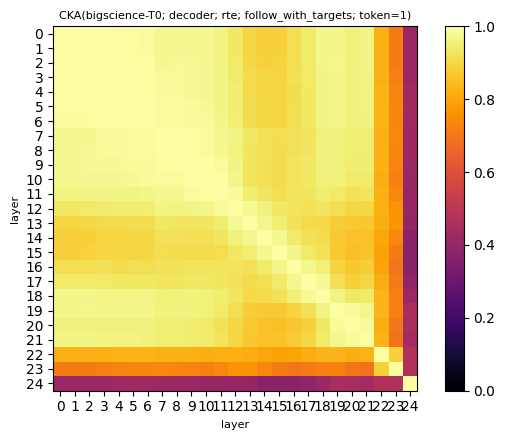

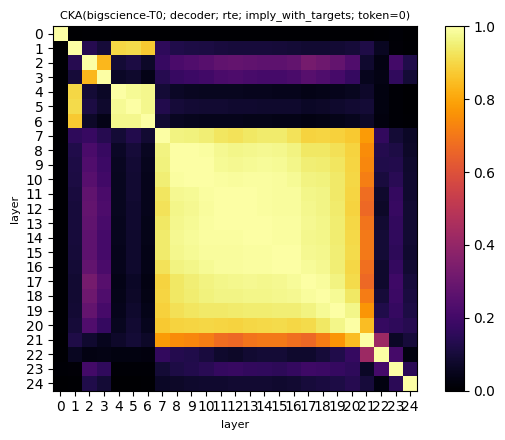

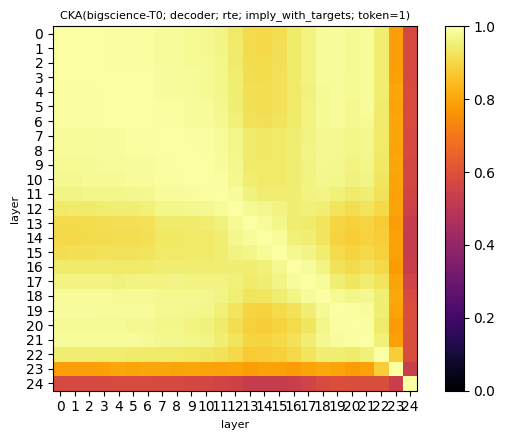

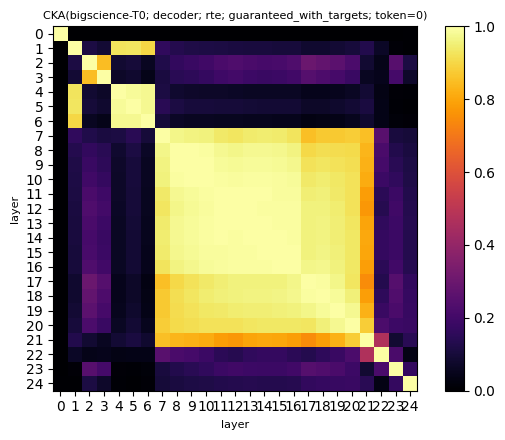

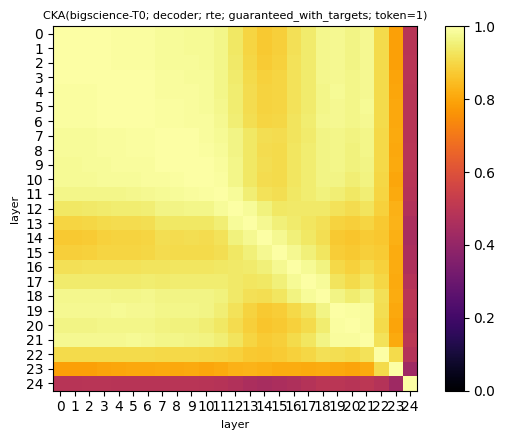

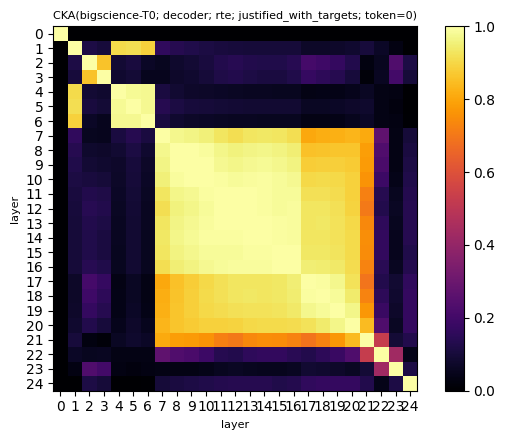

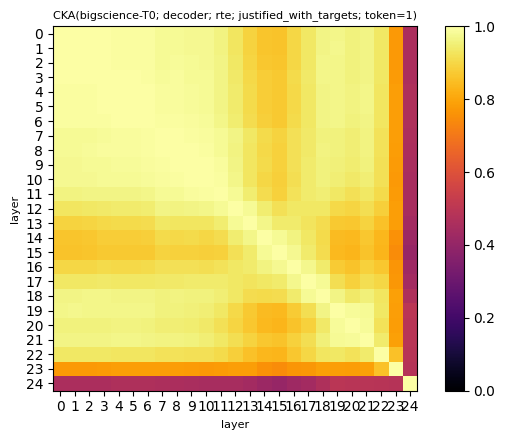

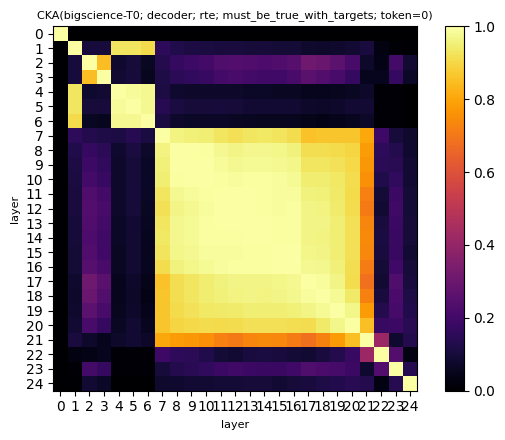

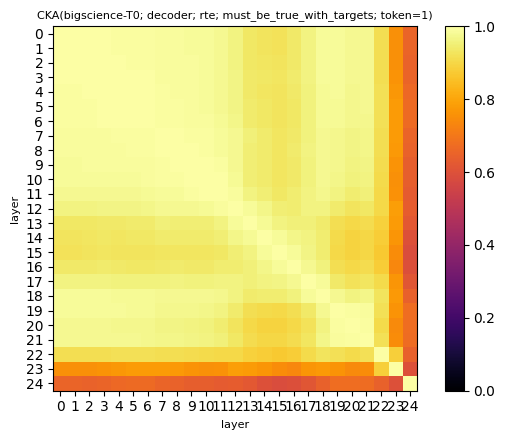

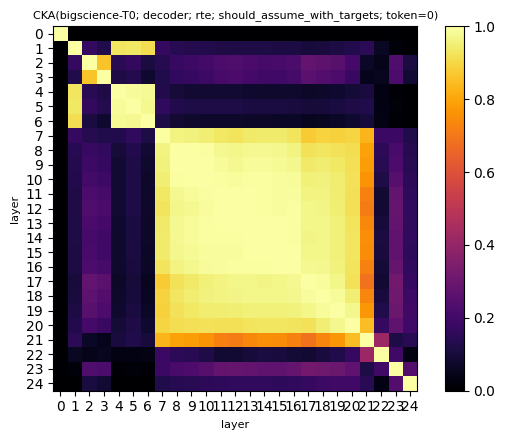

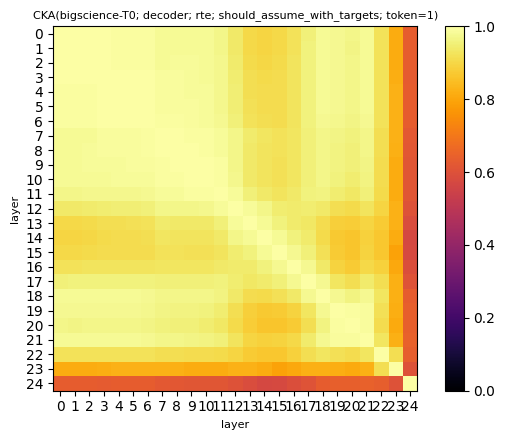

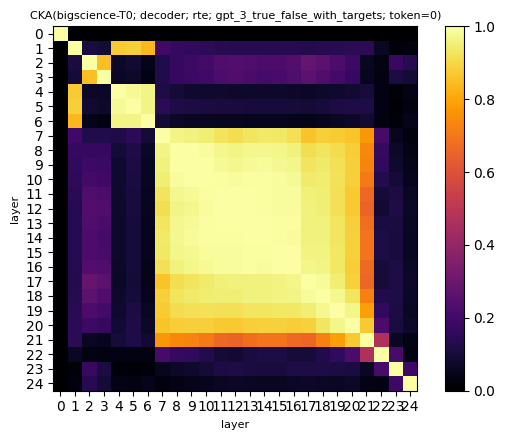

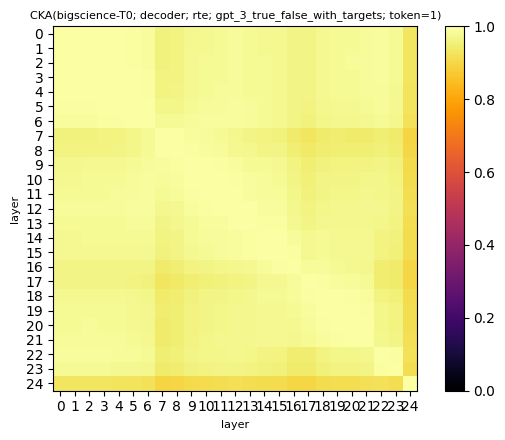

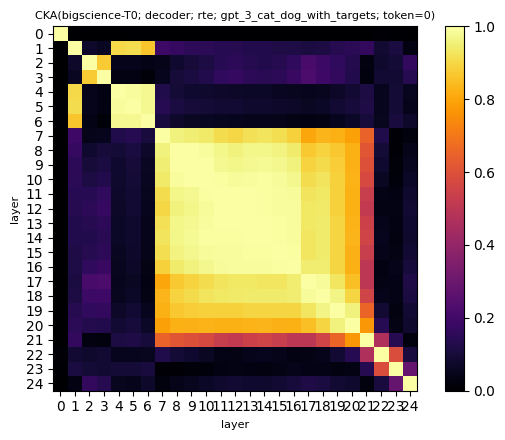

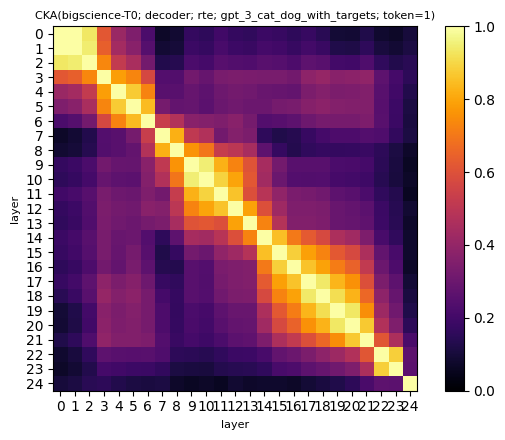

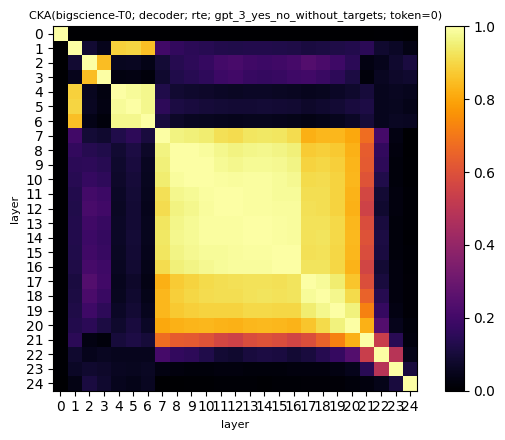

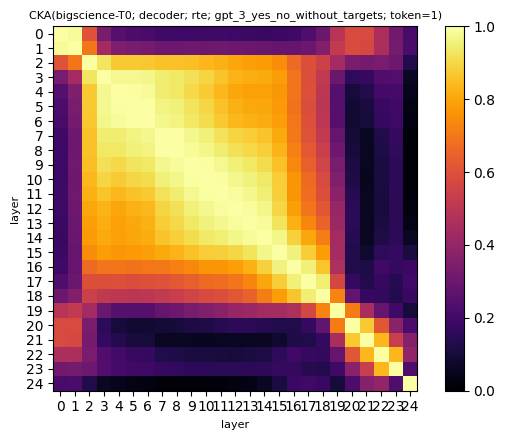

In [10]:
for pattern in list(cka_scores_pattern.keys())[:]:
    for t in range(2):
        values = cka_scores_pattern[pattern][t]

        fig, axes = plt.subplots(1, 1, figsize=(6.0,4.5), dpi=100)

        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        cbar = axes.figure.colorbar(im, ax=axes)
        cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("layer", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("layer", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        axes.set_title(f"CKA({model}; {module}; {task}; {pattern}; token={t})", fontsize=8)

        plt.tight_layout()
        plt.show()
        plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


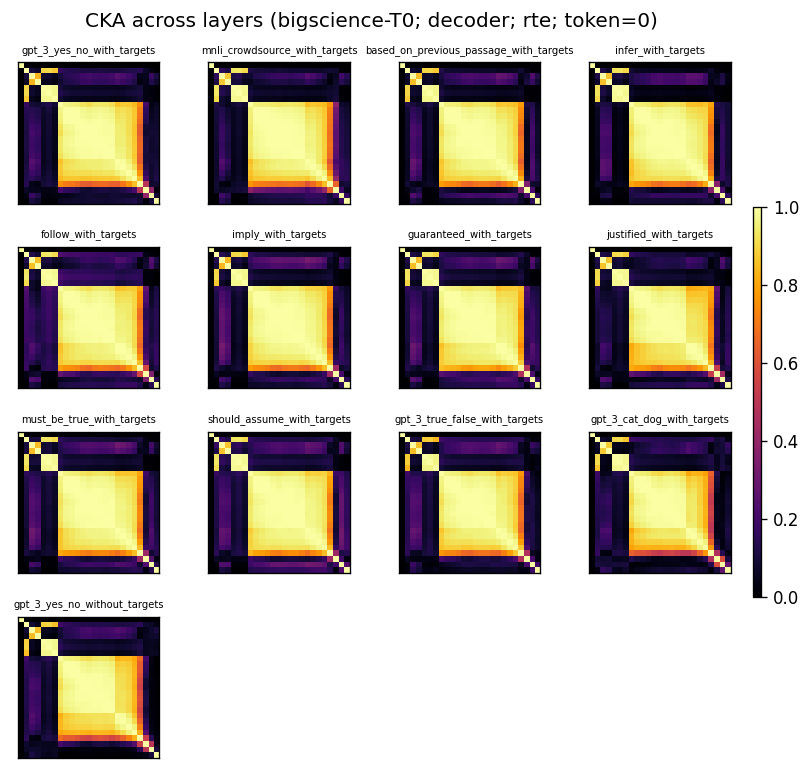

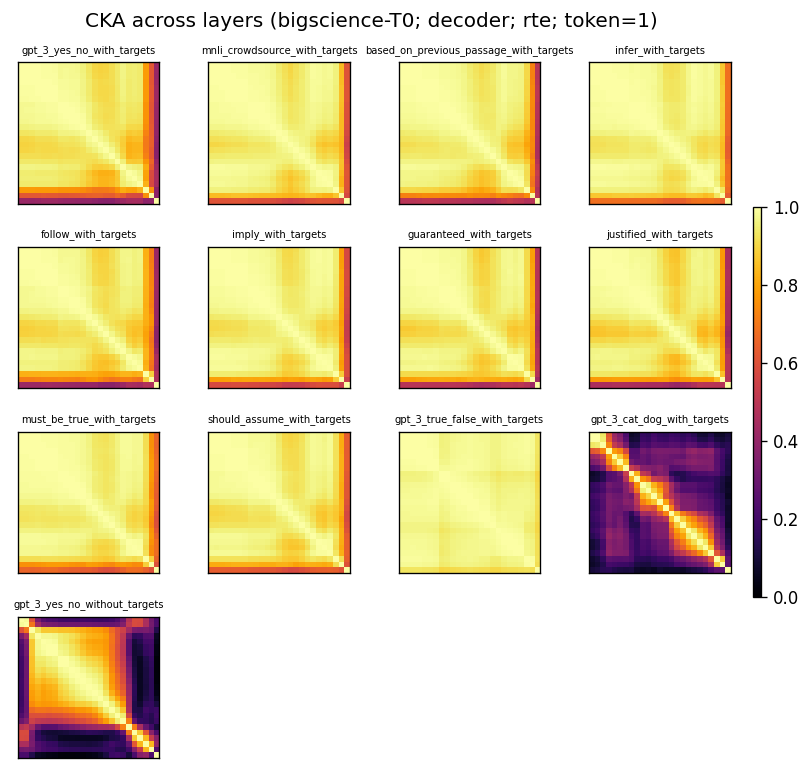

In [11]:
for t in range(2):
    plt.figure(figsize=(6.5, 6.5), dpi=120)

    for l, pattern in enumerate(cka_scores_pattern.keys()):
        values = cka_scores_pattern[pattern][t]

        plt.subplot(4, 4, l+1)
        axes = plt.gca()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
        # Create colorbar
        # cbar = axes.figure.colorbar(im, ax=axes)
        # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

        axes.set_xlabel("template", fontsize=8)
        axes.set_xticks(np.arange(len(values)))
        axes.set_ylabel("template", fontsize=8)
        axes.set_yticks(np.arange(len(values)))

        # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
        axes.set_title(f"{pattern}", fontsize=6)

    # add colorbar
    fig = plt.gcf()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.23, 0.01, 0.5])
    fig.colorbar(im, cax=cbar_ax)

    plt.suptitle(f"CKA across layers ({model}; {module}; {task}; token={t})")
    plt.tight_layout(h_pad=2.0)
    plt.show()
    plt.close();

In [13]:
df

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No","0, 1",False
1,mnli_crowdsource_with_targets,{premise} Using only the above description and...,instructive,True,"▁Yes, ▁No","0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it...",instructive,True,"▁Yes, ▁No","0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothes...",instructive,True,"▁Yes, ▁No","0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypo...,instructive,True,"▁Yes, ▁No","0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hyp...",instructive,True,"▁Yes, ▁No","0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{h...",instructive,True,"▁Yes, ▁No","0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hy...",instructive,True,"▁Yes, ▁No","0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be tru...",instructive,True,"▁Yes, ▁No","0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypoth...",instructive,True,"▁Yes, ▁No","0, 1",False
